In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
from __future__ import print_function

from collections import Counter, OrderedDict

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

# Choose hosts and Load stuff

In [5]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [7]:
hosts_to_target = [h for h in hostlst if h.name in ('Sopranos', 'StarTrek', 'Alice', 'MobyDick')]
assert len(hosts_to_target)==4

In [30]:
# diagnostic
for h in hosts_to_target:
    print(h.name, Counter(h.get_sdss_catalog()['REMOVE']))

Alice Counter({2: 78340, 3: 4377, -1: 582})
Sopranos Counter({-1: 66199, 3: 4090, 2: 751, 4: 663, 1: 14})
MobyDick Counter({-1: 79237, 3: 5848, 2: 426, 1: 24})
StarTrek Counter({2: 86894, 3: 9274, -1: 820})


In [8]:
# now set to the latest base catalogs
for h in hosts_to_target:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [9]:
# actually make sure they're loaded here
for h in hosts_to_target:
    h.get_sdss_catalog()
h.get_sdss_catalog().colnames # just to see

['OBJID',
 'RA',
 'DEC',
 'PHOTPTYPE',
 'PHOT_SG',
 'FLAGS',
 'SATURATED',
 'BAD_COUNTS_ERROR',
 'BINNED1',
 'u',
 'g',
 'r',
 'i',
 'z',
 'u_err',
 'g_err',
 'r_err',
 'i_err',
 'z_err',
 'MODELMAGERR_U',
 'MODELMAGERR_G',
 'MODELMAGERR_R',
 'MODELMAGERR_I',
 'MODELMAGERR_Z',
 'EXTINCTION_U',
 'EXTINCTION_G',
 'EXTINCTION_R',
 'EXTINCTION_I',
 'EXTINCTION_Z',
 'DERED_U',
 'DERED_G',
 'DERED_R',
 'DERED_I',
 'DERED_Z',
 'PETRORAD_U',
 'PETRORAD_G',
 'PETRORAD_R',
 'PETRORAD_I',
 'PETRORAD_Z',
 'PETRORADERR_U',
 'PETRORADERR_G',
 'PETRORADERR_R',
 'PETRORADERR_I',
 'PETRORADERR_Z',
 'DEVRAD_U',
 'DEVRADERR_U',
 'DEVRAD_G',
 'DEVRADERR_G',
 'DEVRAD_R',
 'DEVRADERR_R',
 'DEVRAD_I',
 'DEVRADERR_I',
 'DEVRAD_Z',
 'DEVRADERR_Z',
 'DEVAB_U',
 'DEVAB_G',
 'DEVAB_R',
 'DEVAB_I',
 'DEVAB_Z',
 'CMODELMAG_U',
 'CMODELMAGERR_U',
 'CMODELMAG_G',
 'CMODELMAGERR_G',
 'CMODELMAG_R',
 'CMODELMAGERR_R',
 'CMODELMAG_I',
 'CMODELMAGERR_I',
 'CMODELMAG_Z',
 'CMODELMAGERR_Z',
 'PSFMAG_U',
 'PSFMAGERR_U',
 'P

In [10]:
# these are the already-observed objects
spectra = h.load_and_reprocess_sdss_catalog('SAGADropbox/data/saga_spectra_clean_jan15.fits.gz')

# Generate ranks 

Important difference from previous runs: ML probablities are now in the catalogs!

In [11]:
p_column_for_ranking = 'PROBABILITY_CLASS1' #this is *just* SDSS

Note that the ranking scheme *also* functions as the "filtering" step - anything <=0 doesn't get written

In [17]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    
    photgood = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    
    
    rankdct[h] = ranks = np.zeros(len(cat), dtype=int) #the 0s will be re-set at the end
    
    inside = cat['RHOST_KPC']<300
    # now set the ml prob targets
#     highprob = cat[p_column_for_ranking] > 0.5
#     medprob = (cat[p_column_for_ranking] > 0.05) & ~highprob
#     lowprob = (cat[p_column_for_ranking] > 0.01) & ~highprob & ~medprob
    highprob = cat[p_column_for_ranking] > 0.1
    medprob = (cat[p_column_for_ranking] > 0.01) & ~highprob
    lowprob = (cat[p_column_for_ranking] > 0.001) & ~highprob & ~medprob
    lowestprob = (cat[p_column_for_ranking] > 0.0001) & ~highprob & ~medprob & ~lowprob
    
    # rank 1 reserved for flux stars
    ranks[inside&highprob] = 2
    ranks[~inside&highprob] = 3
    ranks[inside&medprob] = 4
    ranks[~inside&medprob] = 5
    ranks[inside&lowprob] = 6
    ranks[~inside&lowprob] = 7
    ranks[inside&lowestprob] = 8
    ranks[~inside&lowestprob] = 9
    
    
    notML = ranks == 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    ranks[photgood&notML&colorcutmsk] = 10
    ranks[photgood&notML&~colorcutmsk] = 11
    
    #set to-remove objects to ranks<0
    tokeep = cat['REMOVE']==-1
    ranks[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    # and the downloaded rem list
    remmsk = targeting.remove_targets_with_remlist(cat, h, maskonly=True)
    ranks[~remmsk] = -5
    
    # anything that's not ML should have the flag cuts applied (rank<=-10)
    for i, (flag, present) in enumerate([('SATURATED', False), 
                                         ('BAD_COUNTS_ERROR', False), 
                                         ('BINNED1', True)]):
        msk = cat[flag]==0 if present else cat[flag]!=0
        ranks[msk&notML] = -(i+10)
    
    
    # finally, remove already-observed (rank<=-100)
    spec_this_host = spectra[spectra['HOST_NSAID']==h.nsaid]
    spec_this_host = spec_this_host[np.in1d(spec_this_host['OBJID'], cat['OBJID'])]
    
    zq = cat['ZQUALITY'].copy()
    for i, zqi in zip(spec_this_host['OBJID'], spec_this_host['ZQUALITY']):
        zq[cat['OBJID']==i] = zqi
    ranks[zq>2] = -100 - zq[zq>2]
    
    
    if 1237651735756996681 in cat['OBJID']:
        print('Found manual add in', h.name, 'setting rank to 2')
        ranks[cat['OBJID']==1237651735756996681] = 2
    
    #informational
    print(h.name,'rank counts:', Counter(ranks))

Removed 18 objects for Alice
Alice rank counts: Counter({-2: 76020, -104: 2503, -10: 2494, -12: 1812, -105: 237, -103: 115, -3: 56, 0: 30, -5: 18, 11: 12, 3: 1, 10: 1})
Removed 21 objects for Sopranos
Found manual add in Sopranos setting rank to 2
Sopranos rank counts: Counter({0: 47849, 10: 11110, 11: 5547, -10: 2227, -12: 1782, -104: 1398, -2: 741, -4: 643, -105: 171, -3: 73, 9: 44, 8: 43, -5: 22, 7: 21, 5: 15, 6: 13, 4: 9, 2: 4, -103: 4, 3: 1})
Removed 26 objects for MobyDick
MobyDick rank counts: Counter({0: 61284, 10: 10250, 11: 6329, -10: 3681, -12: 2057, -104: 1152, -2: 420, -3: 103, -103: 74, 9: 47, 8: 38, 7: 30, -5: 26, 6: 19, 5: 17, 4: 6, 3: 2})
Removed 9 objects for StarTrek
StarTrek rank counts: Counter({-2: 85842, -10: 7103, -12: 1936, -104: 1758, -3: 220, -103: 88, 0: 20, 11: 10, -5: 9, 8: 1, 9: 1})


### are the ML-selected objects meeting the fibermag and r cuts?

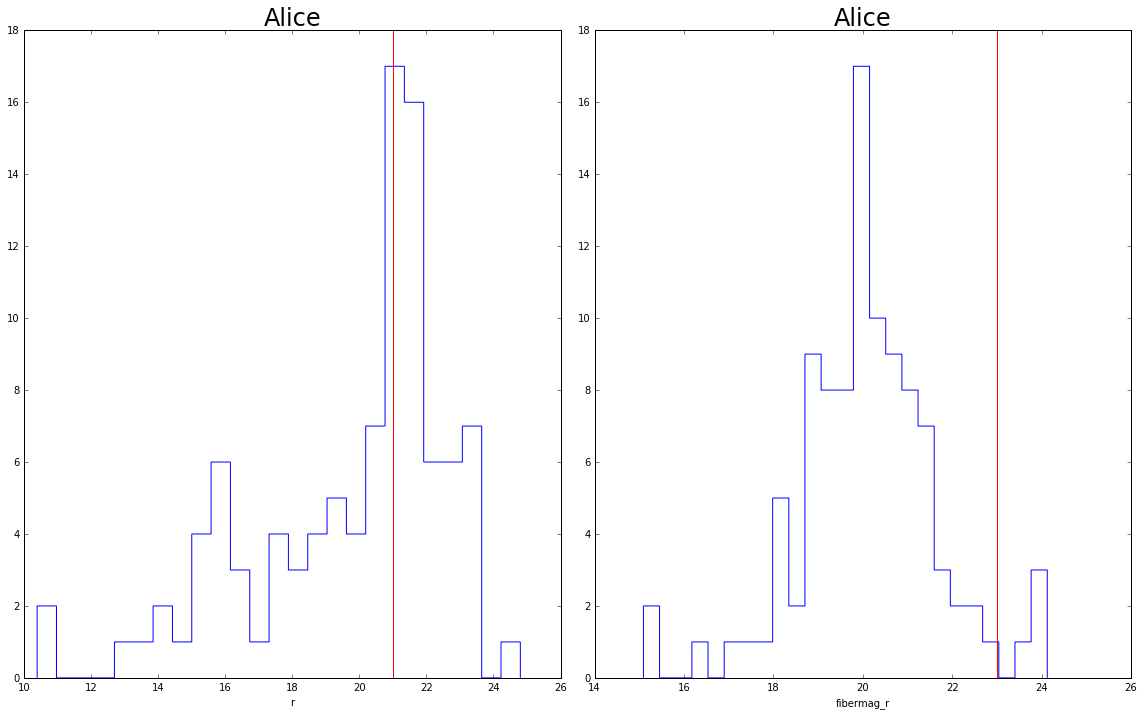

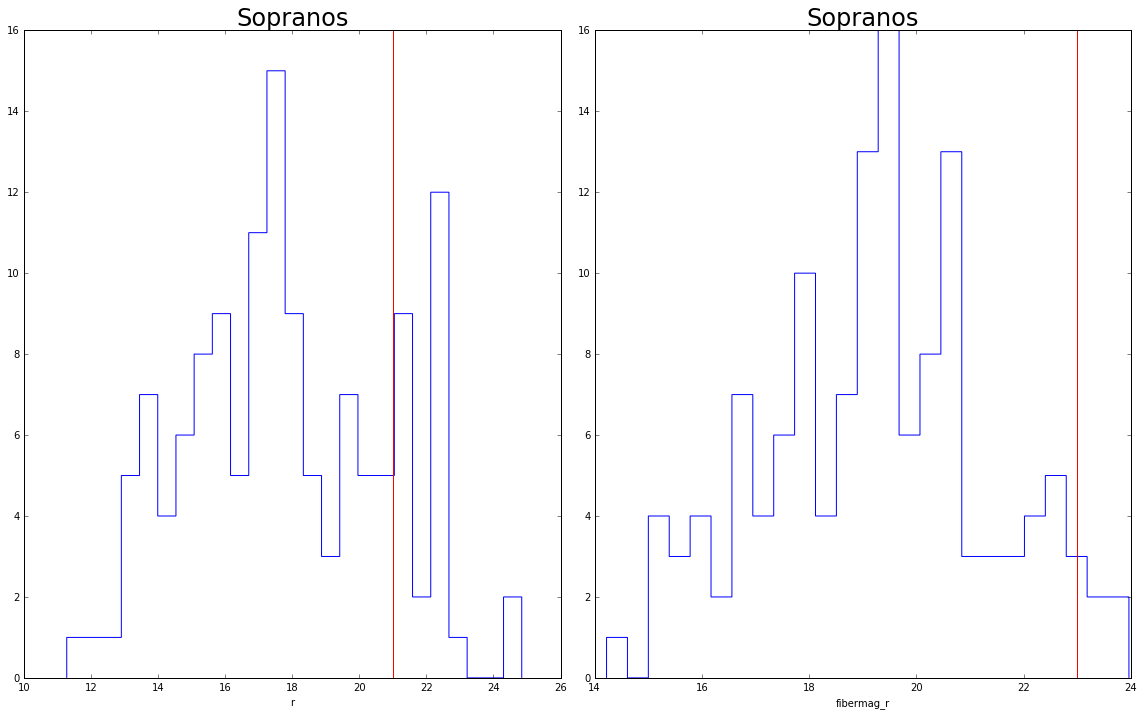

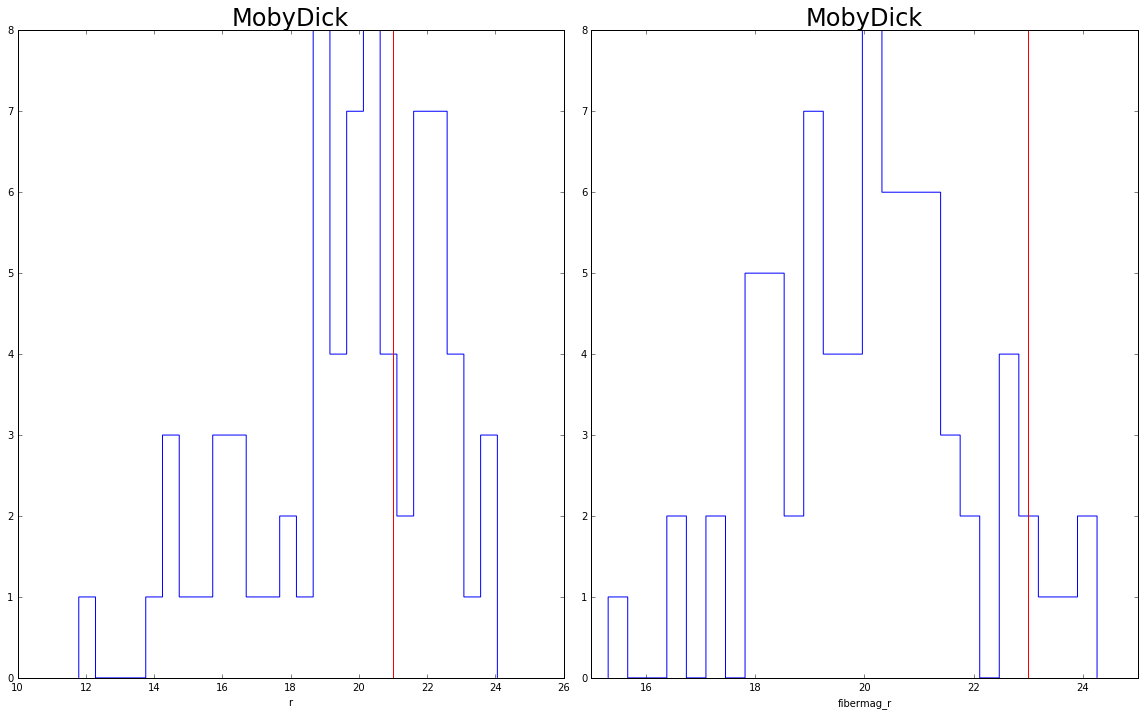

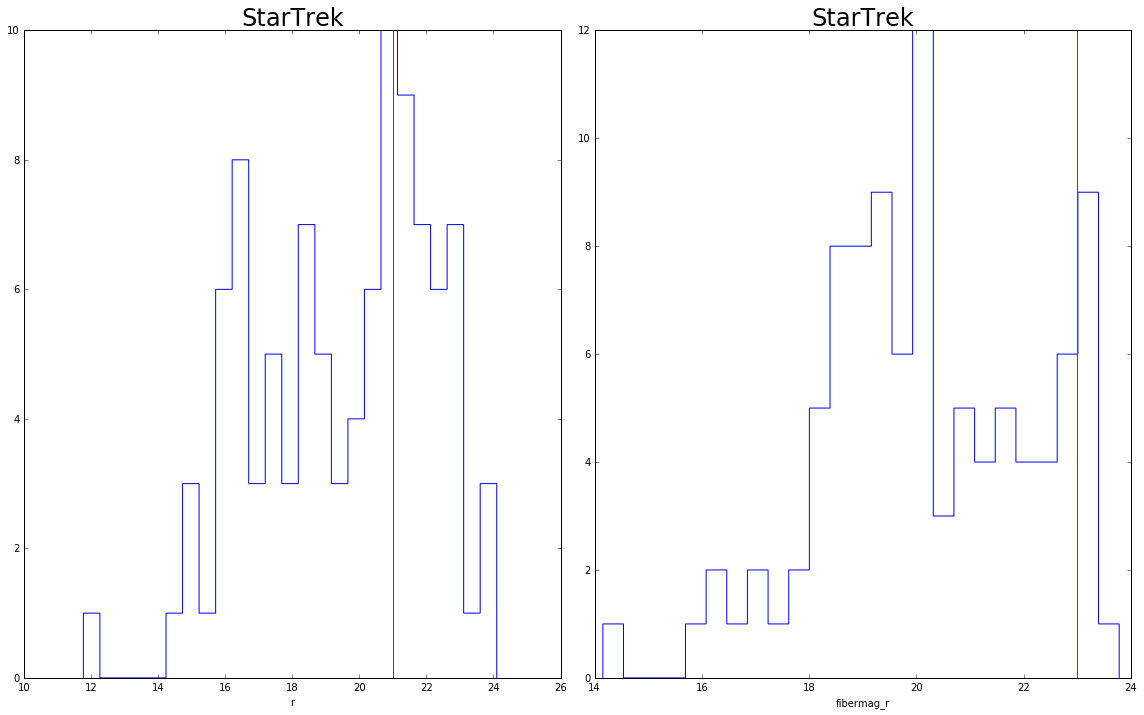

In [18]:
bins = 25
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    plt.figure()
    
    msk = cat[p_column_for_ranking] > 0.01
    plt.subplot(1,2,1)
    ahist(cat[msk]['r'],bins=bins, histtype='step')
    plt.axvline(21,c='r')
    plt.xlabel('r')
    plt.title(h.name, fontsize=24)
    
    plt.subplot(1,2,2)
    ahist(cat[msk]['fibermag_r'],bins=bins, histtype='step')
    plt.axvline(23,c='r')
    plt.xlabel('fibermag_r')
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

### Plot the catalogs as a whole

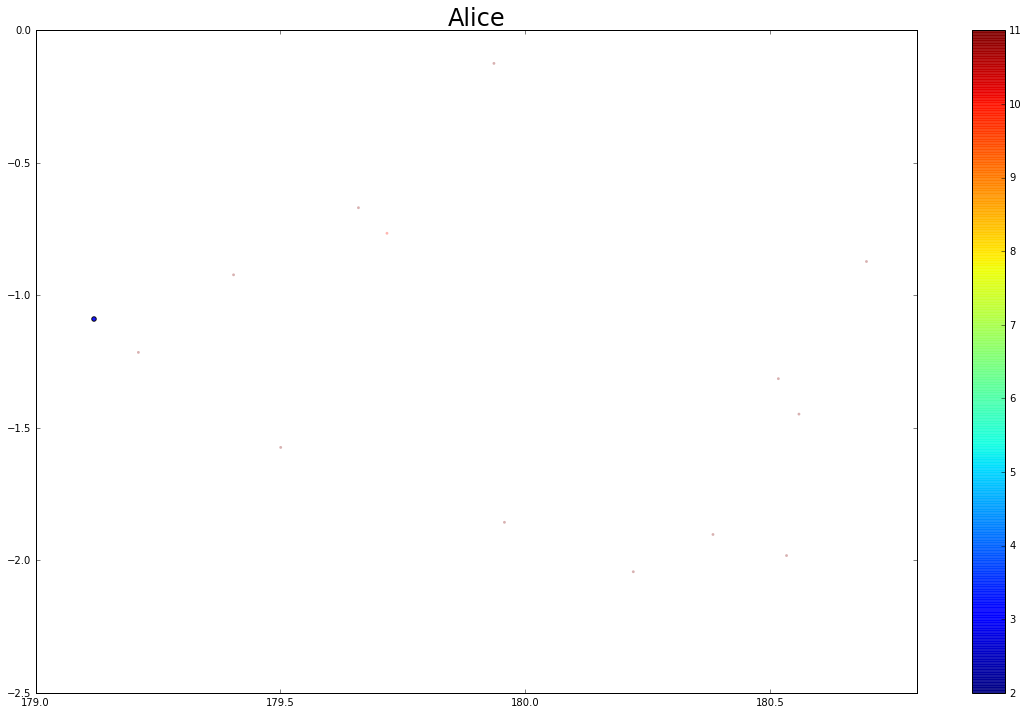

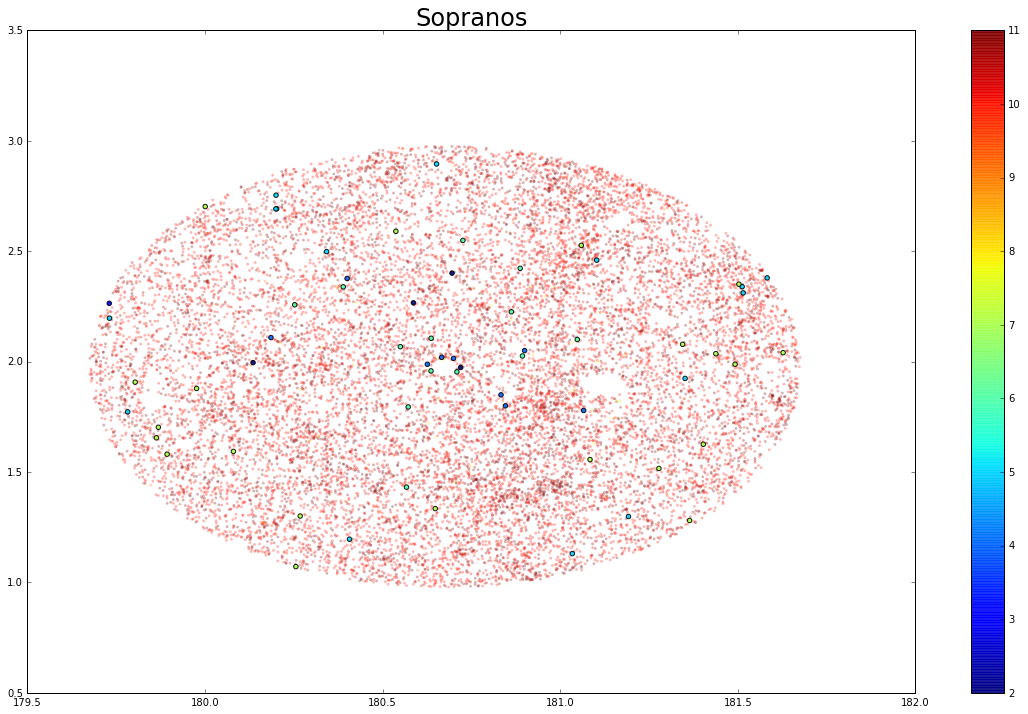

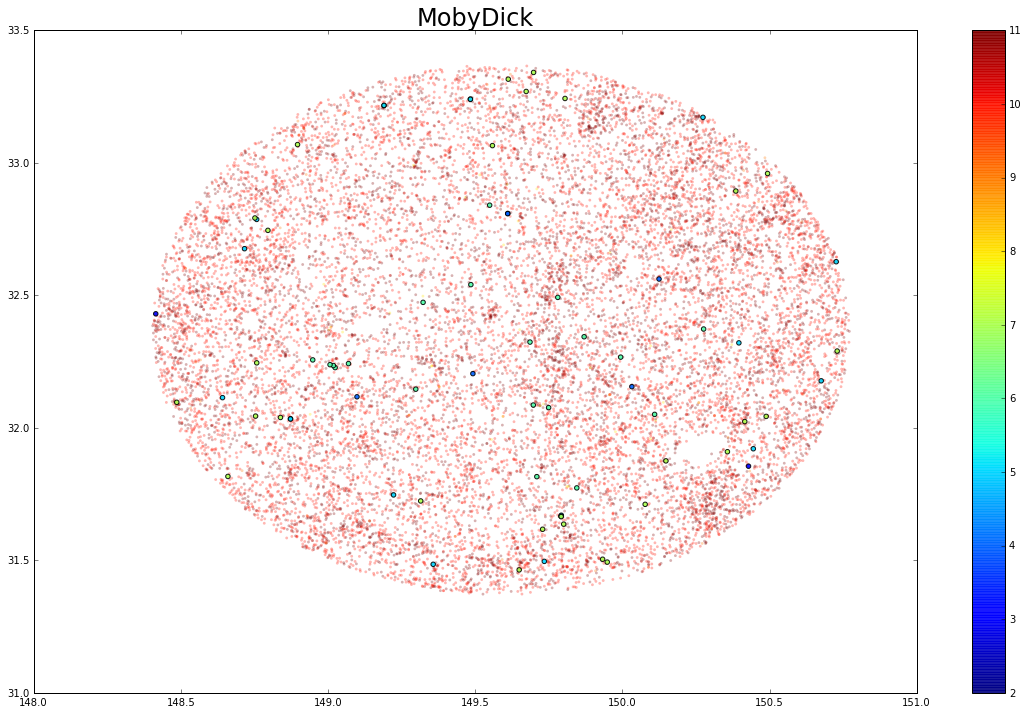

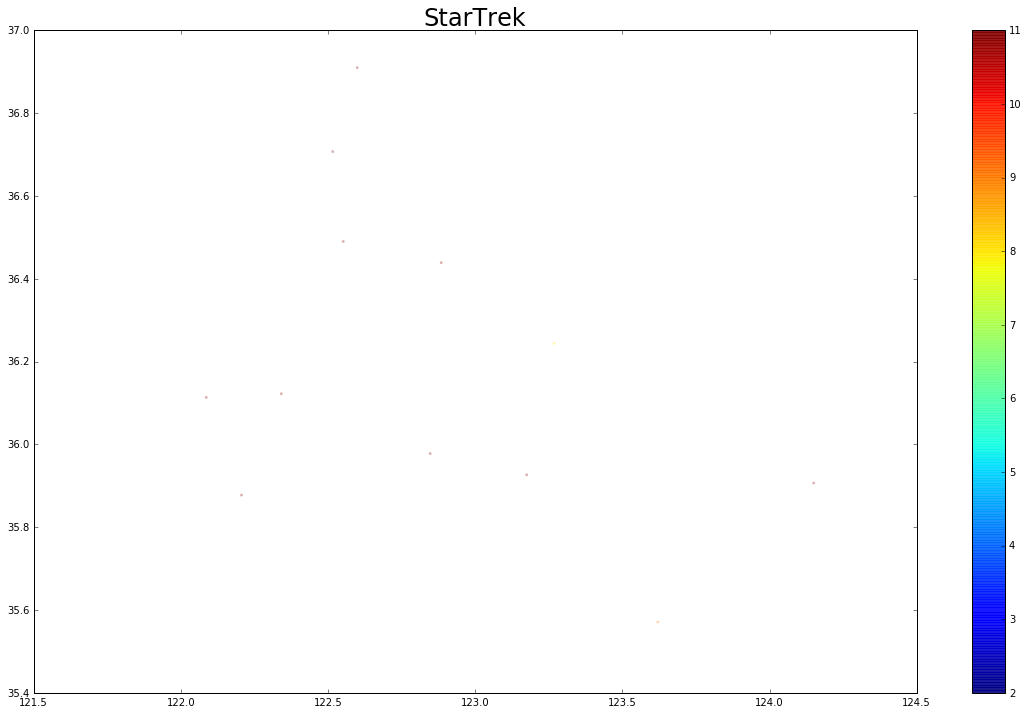

In [19]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    plt.figure()
    
    msk_ml = (ranks>1)&(ranks<8)
    msk_nml = (ranks>7)
    
    plt.scatter(cat['ra'][msk_nml], cat['dec'][msk_nml], lw=0, alpha=.3, c=ranks[msk_nml],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(cat['ra'][msk_ml], cat['dec'][msk_ml], lw=1, alpha=.9, c=ranks[msk_ml],s=20, vmin=2, vmax=np.max(ranks))
    
    plt.colorbar()
    
    
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

### Inspect some objects in the catalog 

In [ ]:
h = [h for h in hosts_to_target if h.name=='Sopranos']
assert len(h)==1
h = h[0]

In [ ]:
cat = h.get_sdss_catalog()
ranks = rankdct[h]

fibmag = cat['fibermag_r']
msk = (ranks>0)&(fibmag>22)#&(ranks<7)

targeting.sampled_imagelist(cat[msk], None, 200, names=['r={0[0]}_fm={0[1]}'.format(t) for t in zip(ranks[msk],fibmag[msk])])
np.sum(msk)

# Generate catalogs 

In [ ]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = h.get_sdss_catalog()
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_feb2016.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<9)
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=1*u.arcmin,
                                         fnout=fnout, fluxfnout=fluxfnout)

### Inspect an output  catalog

In [ ]:
h = [h for h in hosts_to_target if h.name=='Sopranos']
assert len(h)==1
h = h[0]

In [ ]:
gcat = generated_cats[h]

ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)

ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)
{r: np.sum(r==ranknum) for r in set(ranknum)}

In [ ]:
msk = (ranknum>1)&(ranknum<6)  # ML targets
msk = (ranknum>6) #non-ML targets

gcatm = gcat[msk]
targeting.sampled_imagelist(gcatm[np.argsort(gcatm['ra'])], None, 200, names=gcat['rank'][msk])
len(gcatm)

In [ ]:
#identify clumps of nearby objects - note that this is slow for large sets of objects

msk = (ranknum>1)&(ranknum<6)  # ML targets
gcatm = gcat[msk]

gcatmsc = SkyCoord(gcatm['ra'], gcatm['dec'], unit=u.deg)
seps = u.Quantity([c.separation(gcatmsc) for c in gcatmsc])

pairs = zip(*np.where((seps>0.1*u.arcsec)&(seps<10*u.arcsec)))
pairs = [pair for pair in pairs if pair[0]<pair[1]]

clumps = []
for p1, p2 in pairs:
    for clump in clumps:
        if p1 in clump:
            clump.append(p2)
            break
        elif p2 in clump:
            clump.append(p1)
            break
    else:
        clumps.append([p1, p2])
for cl in clumps:
    targeting.sampled_imagelist(gcatm[np.array(cl)], None, None, names=cl)
clumps